In [97]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# NumPy is only used to load the .npz partially processed data file. It is later converted to pandas datasets
from numpy import load
import numpy

# Load the dataset from its location in the Google Drive
data = load('/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

edges
[[    0 18427]
 [18427     0]
 [    1 21708]
 ...
 [ 5563  5563]
 [22425 22425]
 [22425 22425]]
features
[[-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.36413375
  -0.12863389]
 [-0.26257643 -0.26505256 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 ...
 [-0.26257643 -0.27648264 -0.26235026 ... -0.18038896 -0.37209702
  -0.22261272]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.21814811]
 [-0.23227507 -0.27648264 -0.26235026 ... -0.19585785 -0.3759032
  -0.2212746 ]]
target
[0 2 1 ... 2 1 0]


In [99]:
# Load the necessary libraries. TensorFlow is the primary library used

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

Initialise the data

In [100]:
# Load the edges as a pandas dataframe
edges = data["edges"]
edges = pd.DataFrame(data=edges, columns=["source", "target"])

print("Edges shape:", edges.shape)

Edges shape: (342004, 2)


In [101]:
# Generate a sample of the edges data
edges.sample(frac=1).head()

,source,target
277438,9110,17780
336815,21434,19702
317344,16466,19743
241758,10371,2974
257231,16688,11341


In [102]:
# Load the pages as a pandas dataframe
id = numpy.arange(22470)
id = pd.DataFrame(data=id)

categories = data["target"]
categories = pd.DataFrame(data=categories)

pages = data["features"]
pages = pd.DataFrame(data=pages)

pages = numpy.concatenate((id, pages, categories), axis=1)

row_names = ["id"] + [f"term_{idx}" for idx in range(128)] + ["category"]
pages = pd.DataFrame(data=pages, columns=row_names)

N = pages.shape[0] #the number of nodes
F = pages.shape[1] #the number of features

print("Pages shape:", pages.shape)
print('Number of nodes (N): ', N)
print('Number of features (F) of each node: ', F)

Pages shape: (22470, 130)
Number of nodes (N):  22470
Number of features (F) of each node:  130


In [103]:
# Generate a sample of the pages data
print(pages.sample(5).T)

                 18269        4063         4564          16609         20650
id        18269.000000  4063.000000  4564.000000  16609.000000  20650.000000
term_0       -0.219643     1.993175    -0.262576     -0.262576      6.464018
term_1       -0.276483     3.091286    -0.276483     -0.276483     -0.276483
term_2       -0.262350    -0.262350    -0.262350     -0.262350     -0.262350
term_3       -0.284603    -0.299327    -0.299327     -0.299327     -0.299327
...                ...          ...          ...           ...           ...
term_124     -0.255755    -0.255755    -0.255755     -0.255755     -0.255755
term_125     -0.215140    -0.171898    -0.215140     -0.215140     -0.215140
term_126     -0.375903    -0.373249     2.700272      2.697927     -0.375903
term_127     -0.223836     4.877462    -0.223836     -0.223836     -0.223836
category      2.000000     3.000000     1.000000      1.000000      2.000000

[130 rows x 5 columns]


In [104]:
# Display a count of the number of pages in each category, 
# where the category is represented by a number from 0 to 3.
print(pages.category.value_counts())

2.0    6880
1.0    6495
3.0    5768
0.0    3327
Name: category, dtype: int64


In [105]:
# Convert the page id and edge into zero-based indices 
class_values = sorted(pages["category"].unique())

class_idx = {name: idx for idx, name in enumerate(class_values)}
pages["category"] = pages["category"].apply(lambda value: class_idx[value])

page_idx = {name: idy for idy, name in enumerate(sorted(pages["id"].unique()))}
pages["id"] = pages["id"].apply(lambda name: page_idx[name])
edges["source"] = edges["source"].apply(lambda name: page_idx[name])
edges["target"] = edges["target"].apply(lambda name: page_idx[name])

Visualise the graph

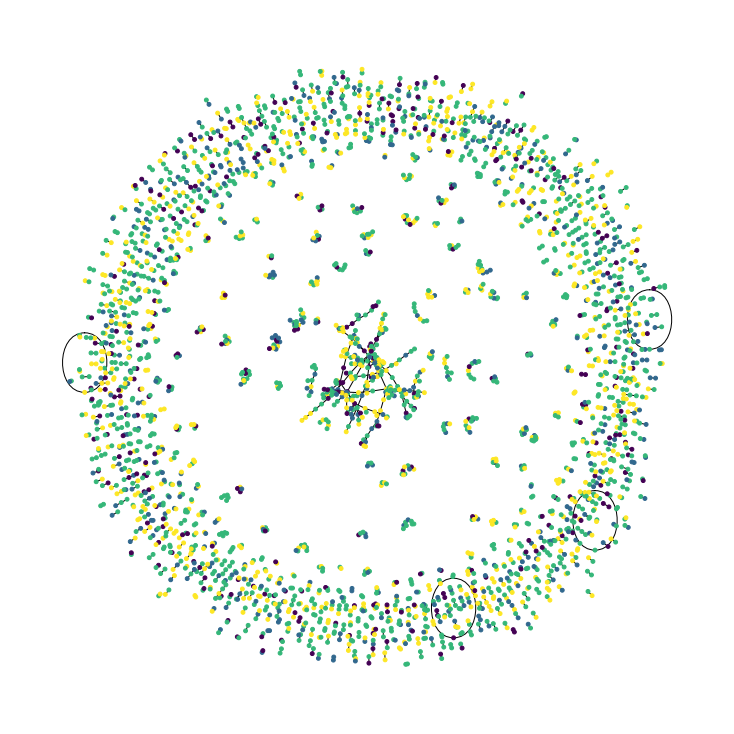

In [106]:
# Plot the graph using a small sample of all the data
plt.figure(figsize=(10, 10))

colours = pages["category"].tolist()

fb_graph = nx.from_pandas_edgelist(edges.sample(n=2000))
page_type = list(pages[pages["id"].isin(list(fb_graph.nodes))]["category"])
nx.draw_spring(fb_graph, node_size=15, node_color=page_type)

In [107]:
# We split the data into train, validation, and test data sets, using a 20:20:60
# train:validation:test split for semi supervised
train_data, val_data, test_data = [], [], []

for _, grouped_data in pages.groupby("category"):
    dataset_length = len(grouped_data.index)
    train_data.append(grouped_data[:dataset_length//10*2])
    val_data.append(grouped_data[dataset_length//10*2:dataset_length//10*4])
    test_data.append(grouped_data[dataset_length//10*4:])

train_data = pd.concat(train_data).sample(frac=1)
val_data = pd.concat(val_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4490, 130)
Validation data shape: (4490, 130)
Test data shape: (13490, 130)


In [108]:
# Prepare the data for training the model
feature_names = set(pages.columns) - {"id", "category"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Convert test, validate, and train pandas datasets features to tensors.
x_train = tf.convert_to_tensor(train_data[feature_names])
x_validate = tf.convert_to_tensor(val_data[feature_names])
x_test = tf.convert_to_tensor(test_data[feature_names])

# Obtain test, validate, and train pandas datasets targets.
y_train = train_data["category"]
y_validate = val_data["category"]
y_test = test_data["category"]

In [109]:
#Create Boolean masks for the train, validate and test datasets
train_mask = numpy.zeros((N,),dtype=bool)
ls_train = [int(x) for x in train_data["id"].tolist()]
train_mask[ls_train] = True

val_mask = numpy.zeros((N,),dtype=bool)
ls_val = [int(x) for x in val_data["id"].tolist()]
val_mask[ls_val] = True

test_mask = numpy.zeros((N,),dtype=bool)
ls_test = [int(x) for x in test_data["id"].tolist()]
test_mask[ls_test] = True

In [110]:
# Encode the labels into one-hot encoding
labels_encoded = []
for value in pages.category:
  letter = [0 for _ in range(len(set(pages.category)))]
  letter[value] = 1
  labels_encoded.append(letter)

In [111]:
# Parameters
channels = 16                 # Number of training channels
stopping_patience = 50        # Patience for early stopping
learning_rate = 0.001         # Learning rate
dropout_rate = 0.5            # Dropout rate for the features
l2_reg = 5*10**(-4)           # Regularisation rate f or l2
num_epochs = 300              # Number of training epochs

In [112]:
!pip install spektral

In [113]:
from spektral.layers import GATConv

# Define the model and create the different layers to be used
X_in = layers.Input(shape=(F, ))
fltr_in = layers.Input((N, ), sparse=True)

dropout_1 = layers.Dropout(dropout_rate)(X_in)
graph_conv_1 = GATConv(channels,
                         activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = layers.Dropout(dropout_rate)(graph_conv_1)
graph_conv_2 = GATConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build the model
model = tf.keras.Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              #weighted_metrics=['acc']),
              metrics=['accuracy']
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 130)          0           input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gat_conv_8 (GATConv)            (None, 16)           2112        dropout_8[0][0]                  
                                                                 input_10[0][0]             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [114]:
X = data["features"]
X = pd.DataFrame(data=pages)
X = numpy.array(X)

# Build the graph
G = nx.Graph()
pages = pages["id"]
pages = numpy.array(pages)
edges = data["edges"]
edges = numpy.array(edges)
G.add_nodes_from(pages)
G.add_edges_from(edges)

# Create the adjacency matrix A from the graph G
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

A = GATConv.preprocess(A).astype('f4')

# Create an early stopping function
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=stopping_patience, restore_best_weights=True
    )

train_mask = numpy.array(train_mask)
val_mask = numpy.array(val_mask)
test_mask = numpy.array(test_mask)
labels_encoded = numpy.array(labels_encoded)


validation_data = ([X, A], labels_encoded, val_mask)

Graph info:  Graph with 22470 nodes and 171002 edges


In [115]:
# Train the model
history = model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=num_epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[early_stopping]
          )

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gat_conv_9/Reshape_5:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_6/gat_conv_9/Reshape_4:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/gat_conv_9/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/gat_conv_9/Reshape_8:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_6/gat_conv_9/Reshape_7:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/gat_conv_9/Cast_2:0", shape=(2,), dtype=int32))) to a

1/1 [==============================] - 6s 6s/step - loss: 1.5045 - acc: 0.3543 - val_loss: 0.7569 - val_acc: 0.2584
Epoch 2/300
1/1 [==============================] - 1s 687ms/step - loss: 1.2150 - acc: 0.3521 - val_loss: 0.4310 - val_acc: 0.2601
Epoch 3/300
1/1 [==============================] - 1s 696ms/step - loss: 0.8143 - acc: 0.3775 - val_loss: 0.4925 - val_acc: 0.2962
Epoch 4/300
1/1 [==============================] - 1s 737ms/step - loss: 1.0926 - acc: 0.3900 - val_loss: 0.7069 - val_acc: 0.2895
Epoch 5/300
1/1 [==============================] - 1s 692ms/step - loss: 0.7888 - acc: 0.4138 - val_loss: 0.9376 - val_acc: 0.2884
Epoch 6/300
1/1 [==============================] - 1s 718ms/step - loss: 0.5225 - acc: 0.4396 - val_loss: 1.1684 - val_acc: 0.2889
Epoch 7/300
1/1 [==============================] - 1s 739ms/step - loss: 0.5783 - acc: 0.4394 - val_loss: 1.3703 - val_acc: 0.2891
Epoch 8/300
1/1 [==============================] - 1s 630ms/step - loss: 0.5342 - acc: 0.4641 - va

In [124]:
# Evaluate the accuracy of the model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X, A], batch_size=N)

report = classification_report(test_mask, numpy.argmax(y_pred,axis=1))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.00      0.00      8980
           1       0.60      0.98      0.75     13490
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.59     22470
   macro avg       0.32      0.25      0.19     22470
weighted avg       0.63      0.59      0.45     22470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
# Create a tSNE embeddings plot 
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations[3])

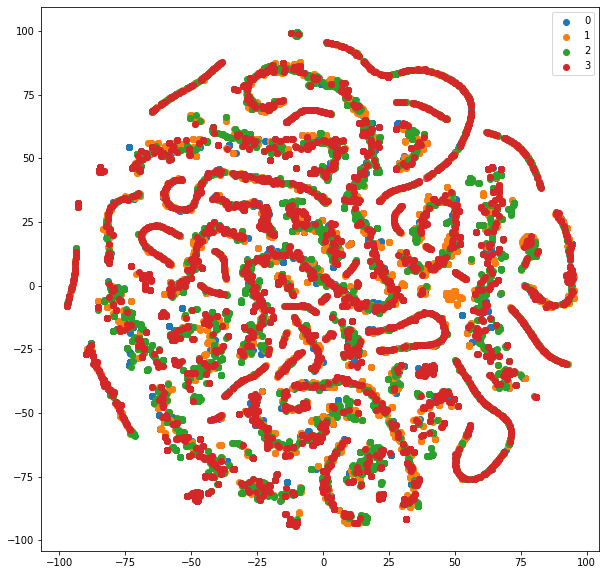

In [118]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = numpy.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = numpy.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

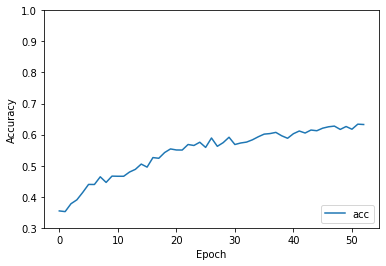

In [121]:
plt.plot(history.history['acc'], label='acc')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.3, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)